# Project Focus:<br>
This dataset contains lot of historical sales data and can be found [here](https://www.kaggle.com/tevecsystems/retail-sales-forecasting). It was extracted from a Brazilian top retailer and has many SKUs and many stores. The data was transformed to protect the identity of the retailer.<br>
### Problem Statement:<br>
Every retail business in the world faces a fundamental question: how much inventory should I carry? In one hand to mush inventory means working capital costs, operational costs and a complex operation. On the other hand lack of inventory leads to lost sales, unhappy customers and a damaged brand.

Current inventory management models have many solutions to place the correct order, but they are all based in a single unknown factor: the demand for the next periods.

This is why short-term forecasting is so important in retail and consumer goods industry.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.api import ExponentialSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels as sm

In [2]:
df = pd.read_csv('retail_data.csv', index_col = 0)

In [3]:
df.head(5)

,venda,estoque,preco
data,,,
2014-01-01,0,4972,1.29
2014-01-02,70,4902,1.29
2014-01-03,59,4843,1.29
2014-01-04,93,4750,1.29
2014-01-05,96,4654,1.29


In [4]:
'''
Convert the index to datetime 
'''
df.index = pd.to_datetime(df.index)

In [5]:
df.index.names = [None]

In [6]:
'''
Changing the column names because they were in Portugese.
'''
df.columns = ['Sale','Quantity','Price']

In [7]:
df.shape

(937, 3)

In [8]:
df.isna().sum()

Sale        0
Quantity    0
Price       0
dtype: int64

In [9]:
df.head(5)

,Sale,Quantity,Price
2014-01-01,0,4972,1.29
2014-01-02,70,4902,1.29
2014-01-03,59,4843,1.29
2014-01-04,93,4750,1.29
2014-01-05,96,4654,1.29


In [10]:
'''
We are going to use ARIMA model to predict the Sales figure based on its historical values. So there weill be no other 
variables. We will drop the other columns.
'''
df.drop(['Quantity', 'Price'], axis = 1, inplace = True)

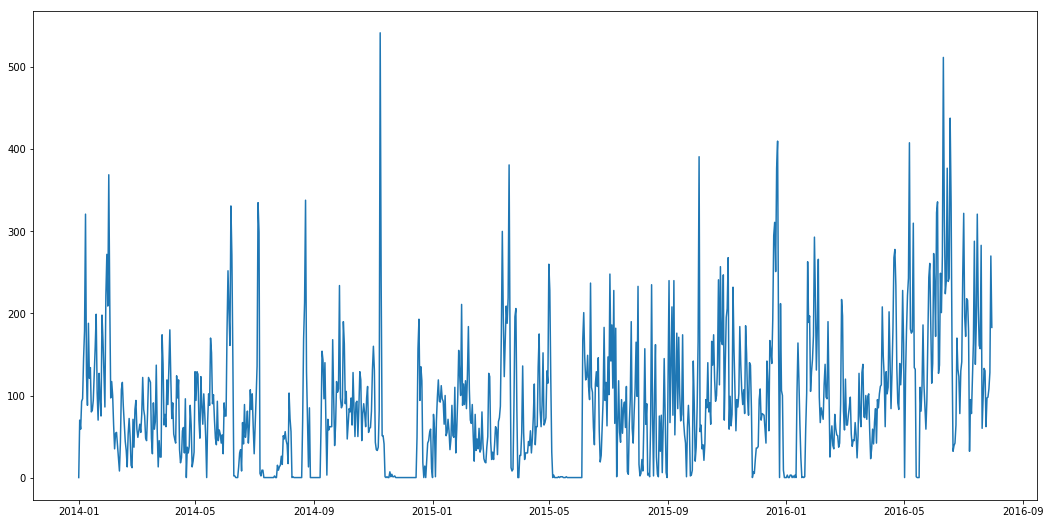

In [12]:
'''
Lets visualize the sales data over time to get the beetr idea of trend and seasonality.
'''
plt.figure(figsize = (18,9))
plt.plot(df);

### Assumption:<br>
ARIMA models work on the assumption of stationarity (i.e. they must have a constant variance and mean). If data has non-stationary, we’ll need to transform it before we can use ARIMA.<br>

**Checks for Stationarity**<br>

1. Look at Plots: plot a run sequence plot to see anything with an obvious trend or seasonal effects<br>
2. Summary Statistics: partition your data into intervals and check for obvious or significant differences in summary statistics<br>
3. Statistical Test: use statistical tests if the expectations of stationarity are met or violated<br>

Here I will be using Augmented Dickey-Fuller test to check stationarity.



In [13]:
def test_stationarity(timeseries, window = 7, cutoff = 0.01):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

In [14]:
test_stationarity(df['Sale'])

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                  -5.326902
p-value                          0.000005
#Lags Used                      14.000000
Number of Observations Used    922.000000
Critical Value (1%)             -3.437462
Critical Value (5%)             -2.864680
Critical Value (10%)            -2.568442
dtype: float64


## Decomposition:<br>
Decomposition is primarily used for time series analysis, and as an analysis tool it can be used to inform forecasting models on our problem.<br>

It provides a structured way of thinking about a time series forecasting problem, both generally in terms of modeling complexity and specifically in terms of how to best capture each of these components in a given model.<BR>

We will use additive model here. As we can see the data shows seasonality over a week period.

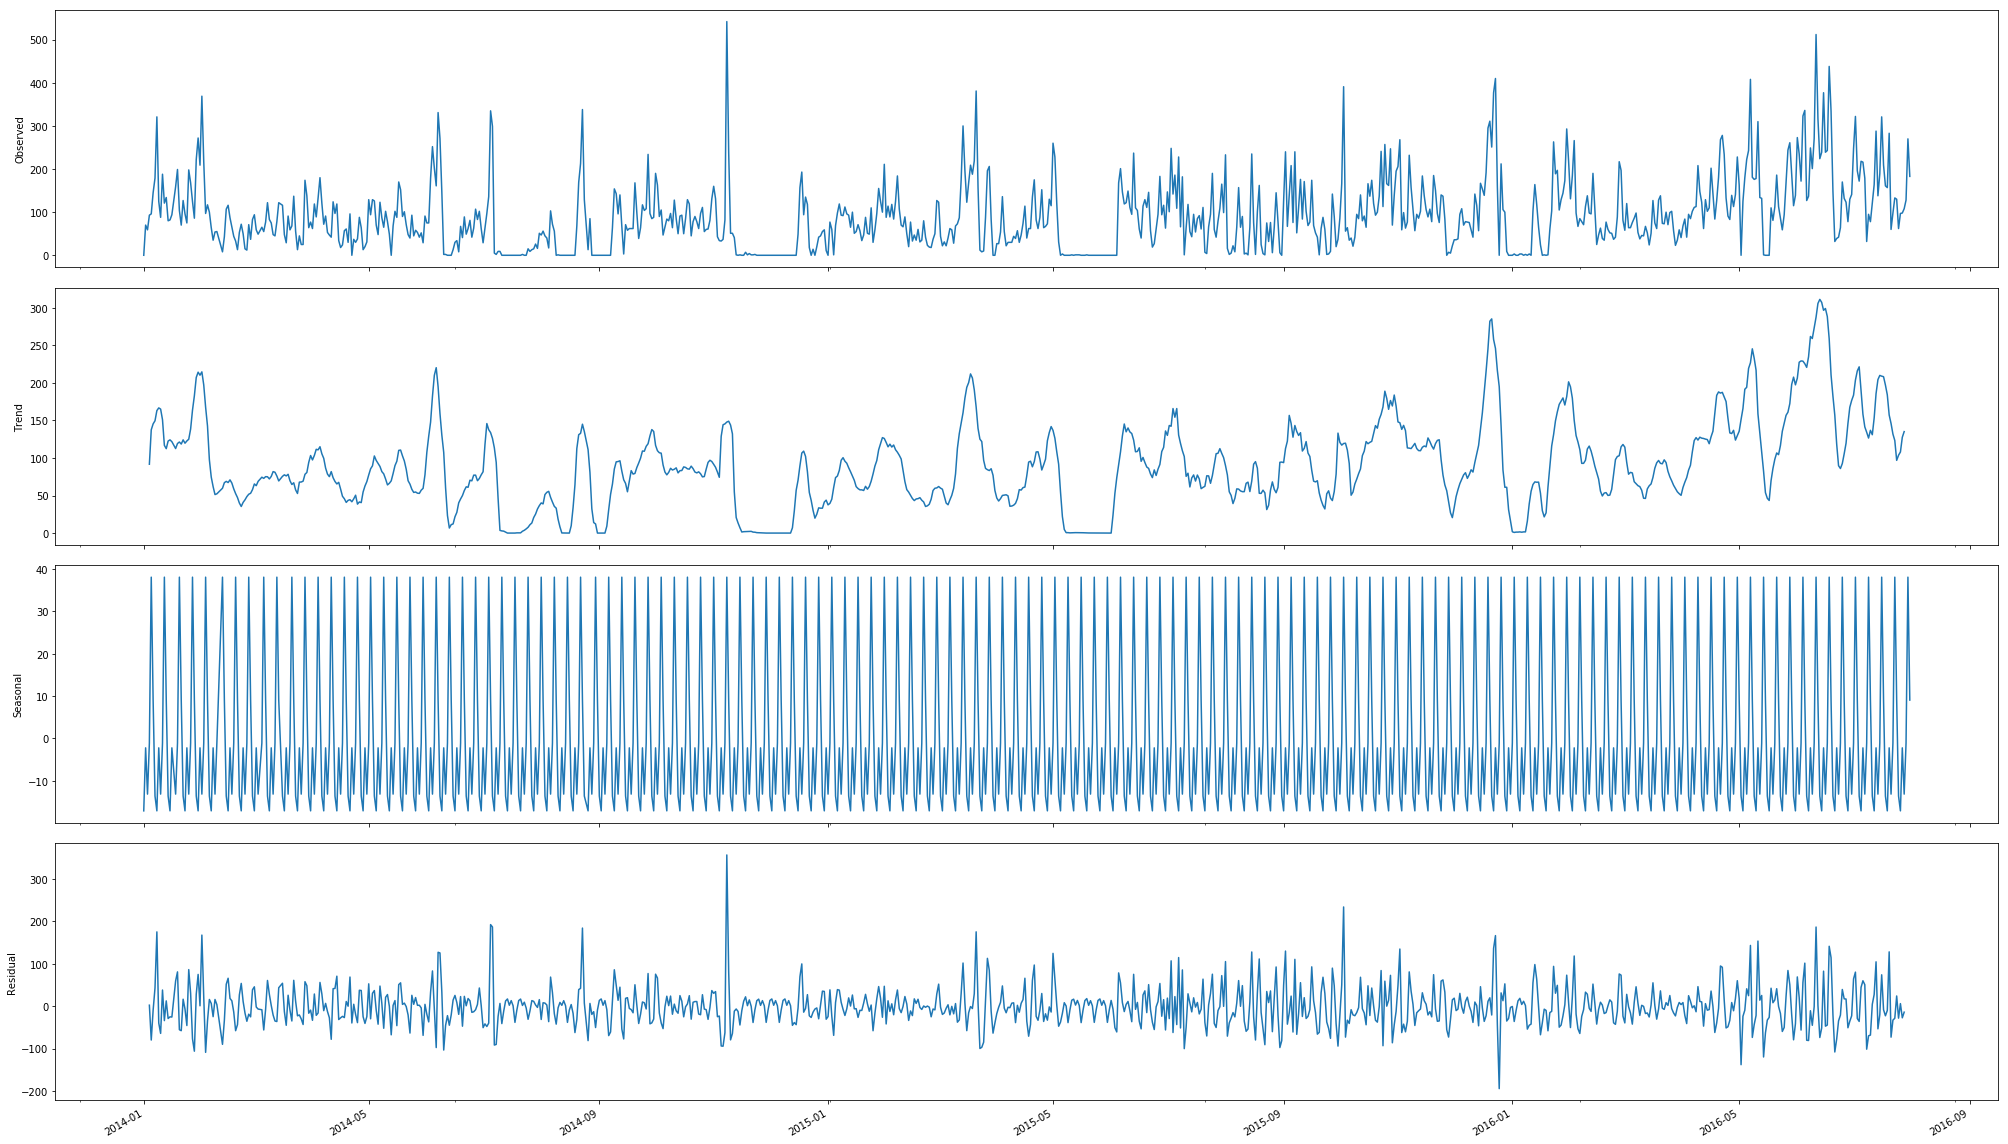

In [15]:
rcParams['figure.figsize'] = 28, 16
decomposition = seasonal_decompose(df, model='additive',freq = 7)
fig = decomposition.plot()
plt.show()

### Autocorrelation function plot (ACF):
Autocorrelation refers to how correlated a time series is with its past values whereas the ACF is the plot used to see the correlation between the points, up to and including the lag unit. In ACF, the correlation coefficient is in the x-axis whereas the number of lags is shown in the y-axis.

Seasonal differencing takes into account the seasons and differences the current value and it’s value in the previous season.

In Purely seasonal AR model, ACF decays slowly while PACF cuts off to zero
AR models are used when seasonal auto-correlation is positive
In Purely seasonal MA model, ACF cuts off to zero and vice versa
MA models are used when seasonal auto-correlation is negative

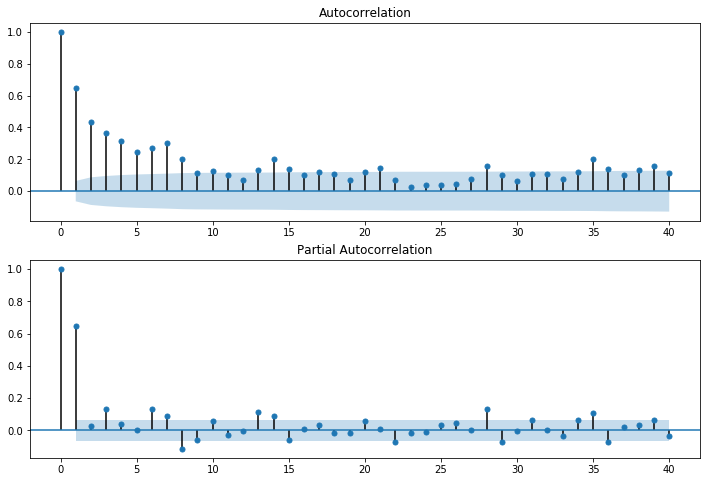

In [166]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsaplots.plot_acf(df, lags=40, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsaplots.plot_pacf(df, lags=40, ax=ax2)

## AR model:<br>
After observing the plots above, I decided to use AR model.<br>
Autoregressive component: A purely AR model forecasts only using a combination of the past values sorta like linear regression where the number of AR terms used is directly proportional to the number of previous periods taken into consideration for the forecasting.

In [16]:
X = df.values
train = X[:901]
test = X[901:]

In [17]:
test.shape

(36, 1)

In [18]:
from statsmodels.tsa.ar_model import AR
model_ar = AR(train)
model_ar_fit = model_ar.fit()

In [19]:
predictions = model_ar_fit.predict(start = 901, end = 936)

In [20]:
rms = sqrt(mean_squared_error(test, predictions))
print(rms)

92.6821687387893


Text(0, 0.5, 'Sale')

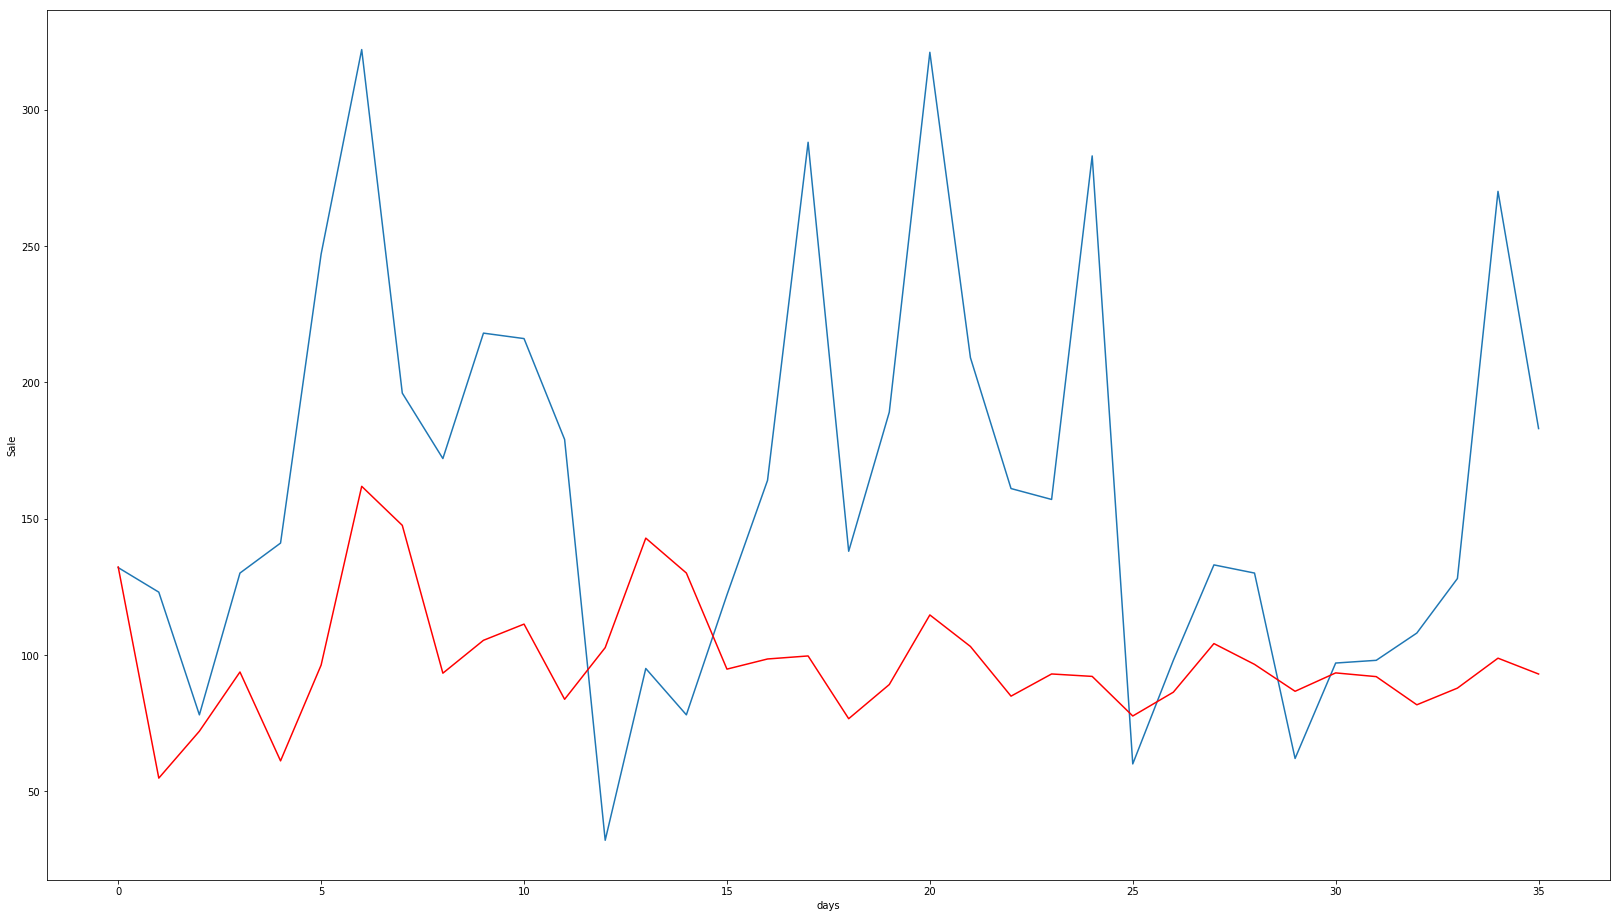

In [25]:
plt.plot(test)
plt.plot(predictions, color = 'red')
plt.xlabel('days')
plt.ylabel('Sale')

### Result:<br>
As we can see above, AR model predictions follow the similar pattern as original data but the predicted values are not quite close enough.

# Seasonal ARIMA (SARIMA) model:<br>

As the name suggests, this model is used when the time series exhibits seasonality. This model is similar to ARIMA models, we just have to add in a few parameters to account for the seasons.<br>
One simple approach is to perform a grid search over multiple values of p,d,q,P,D,and Q using some sort of performance criteria. The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models.<br>
The pyramid-arima library for Python allows us to quickly perform this grid search and even creates a model object that you can fit to the training data. <br>
This library contains an auto_arima function that allows us to set a range of p,d,q,P,D,and Q values and then fit models for all the possible combinations. Then the model will keep the combination that reported back the best AIC value.

In [149]:
train = df.loc['2004-01-01':'2016-06-30']
test = df.loc['2016-07-01':]

In [158]:
stepwise_model = pm.auto_arima(df, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=7,
                           start_P=0, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 7); AIC=10185.536, BIC=10209.712, Fit time=0.809 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 7); AIC=11121.731, BIC=11131.401, Fit time=0.026 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 7); AIC=10490.115, BIC=10509.456, Fit time=0.452 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 7); AIC=10339.606, BIC=10358.947, Fit time=0.712 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 1, 7); AIC=10187.423, BIC=10216.434, Fit time=0.735 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 0, 7); AIC=10736.372, BIC=10755.713, Fit time=0.245 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 2, 7); AIC=10187.421, BIC=10216.432, Fit time=3.232 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 2, 7); AIC=10189.347, BIC=10223.193, Fit time=4.129 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 1, 1, 7); AIC=10188.353, BIC=10217.364, Fit time=1.828 seconds
Fit ARIMA: order=(1

In [143]:
stepwise_model.fit(train)

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(1, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=None, solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)

In [159]:
forecast = stepwise_model.predict(n_periods = 31)

In [160]:
print(forecast)

[127.34335448 126.37076031 181.21675272 134.29174872 147.52981381
 228.7867676  165.0256882  115.90021951 119.15587263 176.73920864
 131.58634556 145.97168474 227.97137735 164.6911429  115.87697054
 119.33415516 177.04796154 131.97956423 146.41958609 228.45467996
 165.19736409 116.39802909 119.86481933 177.58484433 132.52047293
 146.96310113 228.99988234 165.74365884 116.94503103 120.4122791
 178.1326005 ]


In [161]:
rms = sqrt(mean_squared_error(test, forecast))
print(rms)

79.70794699529002


In [162]:
future_forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])
pd.concat([test,future_forecast],axis=1)

,Sale,Prediction
2016-07-01,247,127.343354
2016-07-02,322,126.370760
2016-07-03,196,181.216753
2016-07-04,172,134.291749
2016-07-05,218,147.529814
2016-07-06,216,228.786768
2016-07-07,179,165.025688
2016-07-08,32,115.900220
2016-07-09,95,119.155873
2016-07-10,78,176.739209


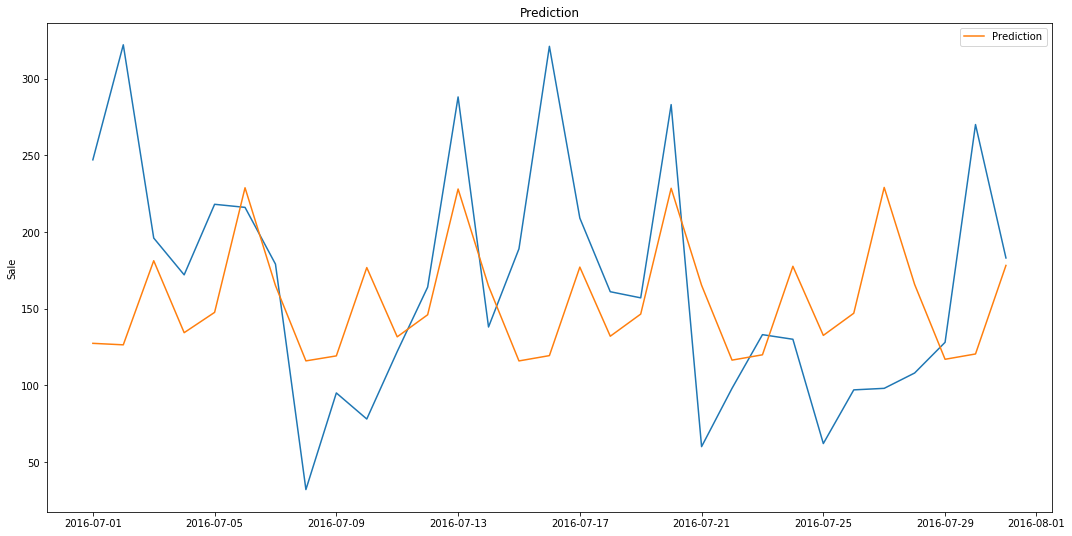

In [163]:
plt.figure(figsize = (18,9))
plt.plot(test)
plt.plot(future_forecast['Prediction'])
plt.ylabel('Sale')
plt.title('Prediction')
plt.legend()
plt.show()

## Result:<br>
As we can see from the graph, the predicted values are much more closer to original values. Seaonal ARIMA performed better than regular AR model.
